In [1]:
# Imports
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from operator import itemgetter
import math

In [75]:
# Setting Directory to the LCR Data Set.
# Then, sets up a Data Frame of the unfiltered data.
# Finally, prints out the unfiltered data as a table.
# os.getcwd()
# os.chdir('/Users/glatiolait/Documents/LCR/LCR_files+scripts')
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",")

print(readed)



# tablelist = list(csv.reader(readed))
# data_array = np.array(readed)
# df = pd.DataFrame(data_array)

# print(df)

         Unnamed: 0        source_name cadence       tmin       tmax  \
0                 0  4FGL J0001.2-0747   daily  239587201  239846401   
1                 1  4FGL J0001.5+2113   daily  239587201  239846401   
2                 2  4FGL J0003.3-1928   daily  239587201  239846401   
3                 3  4FGL J0004.3+4614   daily  239587201  239846401   
4                 4  4FGL J0004.4-4737   daily  239587201  239846401   
...             ...                ...     ...        ...        ...   
4132745     4132745  4FGL J2358.0-4601  weekly  698630401  699235201   
4132746     4132746  4FGL J2358.3-1021  weekly  698630401  699235201   
4132747     4132747  4FGL J2358.3+3830  weekly  698630401  699235201   
4132748     4132748  4FGL J2359.0+3922  weekly  698630401  699235201   
4132749     4132749  4FGL J2359.2-3134  weekly  698630401  699235201   

         photon_flux2  photon_flux_error2  photon_index2  return_code2   ts2  
0        2.720000e-08        3.300000e-08           2.18

In [76]:
# Prompts the User for a selection of Cadence values. 
# I accounted for possible misspellings regarding capitalization.
# If the cadence value inputted is incorrect, then an error is displayed.
# The function then takes the inputted cadence string, and filters the DataFrame table with that.

cadence = input("Input Cadence Selection. (daily, weekly, or monthly) Case Sensitive.")
if cadence not in ['daily', 'Daily', 'weekly', 'Weekly', 'monthly', 'Monthly']:
    print("Error. Invalid option")



In [32]:

# This section takes the user input for cadence, and then outputs a data set for a random source within that cadence value.
# The randomsource variable takes a random name from the list, so some sources may be weighted far more heavily than others.
# I am not sure if the randomness is necessary, but it allowed an easy way to test multiple graphs.
# I have also included a default source name to check against consistently.
# randomsource = np.random.choice(data_array[:,1])
randomsource = '4FGL J0001.2-0747'
randomsource_df = readed.loc[(readed['source_name'] == randomsource) & \
                             (readed['cadence'] == cadence)# & \
                             (readed['ts2'] <= 4.) & \
                             (readed['photon_flux_error2'] <  readed['photon_flux2'])
                            ]

# Prints out which source was randomly picked. Not necessary for using the default option.
# print(randomsource)

# Filters the catalogue to only randomsource, cadence, sigma values larger than 4, and photon flux values greater than their error margins.
# sortedsource = np.where((data_array[:,1] == randomsource) & (data_array[:,2]==cadence) & (data_array[:,-1] >= 4) & (data_array[:,6] < data_array[:,5]))

# # Displays the dataframe to ensure everything is working as intended. Will omit in the future.
# pd.DataFrame(data_array[sortedsource])

In [77]:

cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
print(cadence_df)

TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

         Unnamed: 0        source_name cadence       tmin       tmax  \
3050           3050  4FGL J0001.2-0747  weekly  239587201  240192001   
3051           3051  4FGL J0001.5+2113  weekly  239587201  240192001   
3052           3052  4FGL J0003.3-1928  weekly  239587201  240192001   
3053           3053  4FGL J0004.3+4614  weekly  239587201  240192001   
3054           3054  4FGL J0004.4-4737  weekly  239587201  240192001   
...             ...                ...     ...        ...        ...   
4132745     4132745  4FGL J2358.0-4601  weekly  698630401  699235201   
4132746     4132746  4FGL J2358.3-1021  weekly  698630401  699235201   
4132747     4132747  4FGL J2358.3+3830  weekly  698630401  699235201   
4132748     4132748  4FGL J2359.0+3922  weekly  698630401  699235201   
4132749     4132749  4FGL J2359.2-3134  weekly  698630401  699235201   

         photon_flux2  photon_flux_error2  photon_index2  return_code2   ts2  
3050              NaN                 NaN            NaN

In [ ]:
def ransource():
    # This function takes the user input for cadence, and then outputs a data set for a random source within that cadence value.
    # I am not sure if the randomness is necessary, but it allowed an easy way to test multiple graphs.
    
    names = df.drop_duplicates(subset=[1], inplace=False)[1]
    randomsource = np.random.choice(names)

    print(randomsource)

    # Filters the catalogue to only randomsource, cadence, sigma values larger than 4, and photon flux values greater than their error margins.
    sortedsource = np.where((data_array[:,1] == randomsource) & (data_array[:,2]==cadence) & (data_array[:,-1] >= 4) & (data_array[:,6] < data_array[:,5]))

    # Displays the dataframe to ensure everything is working as intended. Will omit in the future.
    #pd.DataFrame(data_array[sortedsource])

    # This block of code is where a majority of the plots will go.

    GraphTest = (data_array[sortedsource])
    Plot = pd.DataFrame(GraphTest)
    ysize = GraphTest.size
    x = pd.DataFrame(GraphTest[:,3]/(60*60*24*365))

    # The title displays the name of the graph, with references that will vary the cadence and name of the source.
    plt.title("Photon Flux vs " + GraphTest[0,2] + " Cadence of " + GraphTest[0,1])

    # The x-axis displays the time elapsed in seconds. I would like to convert this to be a range of years.
    plt.xlabel("Mission Elapsed Time (seconds)")

    # The y-axis displays the Photon Flux. I don't believe the numerical labels are correct, but the shape of the graph appears to be correct.
    plt.ylabel("Photon Flux (GeV ph cm^-2 s^-1)")

    # This is the actual function that plots the data. At the moment, it plots column 3 (Time) vs column 5 (Photon Flux)
    #Graph = plt.plot(Plot[3],Plot[5])
    plt.errorbar(Plot[3],Plot[5],yerr=Plot[6],fmt = 'o-')
    plt.hlines(np.mean(GraphTest[:,5]),2e8,7e8)


In [78]:
# This loop processes the entire database
# It goes through each source, and determines the average flux of the entire source, and the fraction of the flux at each of those time bins.

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]
print(names, len(names))


['4FGL J0001.2-0747' '4FGL J0001.5+2113' '4FGL J0003.3-1928' ...
 '4FGL J2358.3-1021' '4FGL J2359.0+3922' '4FGL J2359.2-3134'] 1525


In [38]:
fmatrix = []
fractionalflux = []
for i, name in enumerate(names):
    print(i, name)
    source_array = cadence_df.loc[cadence_df['source_name'] == name]
    averageflux = np.nanmean(source_array['photon_flux2'])
    flux = np.array(source_array['photon_flux2'])
    flux_err = np.array(source_array['photon_flux_error2'])

    factors = flux/averageflux
    fmatrix.append(factors.tolist())
    fractionalflux.append([name,factors,averageflux,flux,flux_err])
# pd.DataFrame(fractionalflux)

fmatrix = np.array(fmatrix)
print(fmatrix.shape)

0 4FGL J0001.2-0747
760
1 4FGL J0001.5+2113
760
2 4FGL J0003.3-1928
760
3 4FGL J0004.3+4614
760
4 4FGL J0004.4-4001
760
5 4FGL J0004.4-4737
760
6 4FGL J0005.9+3824
760
7 4FGL J0007.7+4008
760
8 4FGL J0009.1-5012
760
9 4FGL J0009.3+5030
760
10 4FGL J0010.6+2043
760
11 4FGL J0010.6-3025
760
12 4FGL J0011.4+0057
760
13 4FGL J0014.1+1910
760
14 4FGL J0014.3-0500
760
15 4FGL J0014.9+3212
760
16 4FGL J0016.2-0016
760
17 4FGL J0017.0-0649
760
18 4FGL J0017.5-0514
760
19 4FGL J0019.2-5640
760
20 4FGL J0019.6+7327
760
21 4FGL J0021.5-2552
760
22 4FGL J0021.9-5140
760
23 4FGL J0022.5+0608
760
24 4FGL J0023.7+4457
760
25 4FGL J0023.7-6820
760
26 4FGL J0024.4+4647
760
27 4FGL J0024.7+0349
760
28 4FGL J0025.7-4801
760
29 4FGL J0028.4+2001
760
30 4FGL J0029.0-7044
760
31 4FGL J0030.2-1647
760
32 4FGL J0030.3-4224
760
33 4FGL J0030.6-0212
760
34 4FGL J0032.3-5522
760
35 4FGL J0033.5-1921
760
36 4FGL J0033.9+3858
760
37 4FGL J0034.0-4116
760
38 4FGL J0035.2+1514
760
39 4FGL J0035.8+6131
760
40 4FGL J0

/var/folders/c_/m9xq6z1d7ng4l884vymz4c240000gq/T/ipykernel_88994/173552242.py:6: RuntimeWarning: Mean of empty slice
  averageflux = np.nanmean(source_array['photon_flux2'])


760
671 4FGL J1038.2-2425
760
672 4FGL J1038.8-5312
760
673 4FGL J1040.5+0617
760
674 4FGL J1043.2+2408
760
675 4FGL J1044.6+8053
760
676 4FGL J1045.1-5940
760
677 4FGL J1045.8-2928
760
678 4FGL J1047.2+6740
760
679 4FGL J1047.2-5517
760
680 4FGL J1047.7+7238
760
681 4FGL J1047.8-6216
760
682 4FGL J1048.4+7143
760
683 4FGL J1049.8+1429
760
684 4FGL J1050.1+0432
760
685 4FGL J1051.4-3139
760
686 4FGL J1051.6+2109
760
687 4FGL J1051.6+3253
760
688 4FGL J1054.5+2211
760
689 4FGL J1056.8+7012
760
690 4FGL J1057.2+5510
760
691 4FGL J1057.3-2341
760
692 4FGL J1058.0+4305
760
693 4FGL J1058.4+0133
760
694 4FGL J1058.5+8115
760
695 4FGL J1058.6+2817
760
696 4FGL J1058.6+5627
760
697 4FGL J1058.6-8003
760
698 4FGL J1059.2-1134
760
699 4FGL J1059.5+2057
760
700 4FGL J1102.6+5251
760
701 4FGL J1103.0+1157
760
702 4FGL J1103.9-5357
760
703 4FGL J1104.4+0730
760
704 4FGL J1104.4+3812
760
705 4FGL J1104.9+5748
760
706 4FGL J1106.0+2813
760
707 4FGL J1106.5-3646
760
708 4FGL J1106.7+3623
760
709 4FGL

In [39]:
# This is just for making the files look nicer. I dont believe that this will affect the actual arrays.
fractionalflux = pd.DataFrame(fractionalflux).rename(columns={0: 'source_name', 1: 'flux_values',2: 'average_flux'})

array([[       nan, 0.38154008,        nan, ..., 0.94961086,        nan,
               nan],
       [0.15012723, 0.19070215,        nan, ...,        nan, 0.10346606,
               nan],
       [       nan,        nan, 0.05483926, ..., 0.31572196,        nan,
               nan],
       ...,
       [0.86478943,        nan,        nan, ...,        nan, 0.7353524 ,
               nan],
       [0.42242599,        nan, 0.11678836, ...,        nan,        nan,
               nan],
       [       nan,        nan, 2.18750057, ..., 0.47013287,        nan,
               nan]])

KeyError: 0

/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpecte

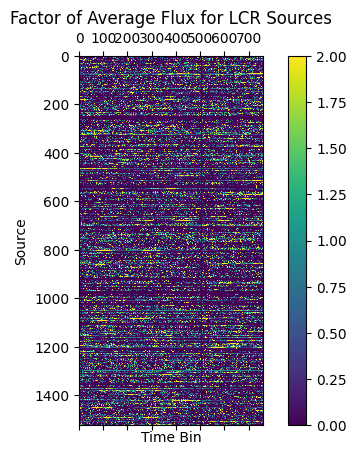

In [40]:
# This section plots each fractional point as a color-coded plot. 
# Currently Playing with different methods of adding labels to the left side of the plot.
# fmatrix=np.array(fmatrix)
fmatrix = np.nan_to_num(fmatrix.astype(np.float64), nan=0.0)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(fmatrix,interpolation='nearest')
fig.colorbar(cax)
cax.set_clim(0,2)
ax.set_title("Factor of Average Flux for LCR Sources")
ax.set_xlabel("Time Bin")
ax.set_ylabel("Source")
alpha = pd.DataFrame(fractionalflux)[0].tolist()
plt.yticks(np.arange(0,len(alpha),1.0))
#ax.imshow(fmatrix, extent = [0,3000,0,10000], aspect ='auto')
#ax.get_yticks()
#ax.set_yticklabels(['']+alpha)


In [79]:
from fractional_variability import fvar, fvar_percent
from fermi_catalog import select_bll, select_fsrq, select_bcu, select_allblazars

In [80]:

bll_df = select_bll()
# ...
bll_names = bll_df['Source_Name']

bll_fmatrix = []
bll_fractionalflux = []
for i, bll in enumerate(bll_names):
    print(i, bll)
    source_array = cadence_df.loc[cadence_df['source_name'] == bll]
    averageflux = np.nanmean(source_array['photon_flux2'])
    flux = np.array(source_array['photon_flux2'])
    flux_err = np.array(source_array['photon_flux_error2'])

    factors = flux/averageflux
    bll_fmatrix.append(factors.tolist())
    bll_fractionalflux.append([name,factors,averageflux,flux,flux_err])

bll_fmatrix = np.array(bll_fmatrix)


-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477
0 4FGL J0001.2-0747
1 4FGL J0009.3+5030
2 4FGL J0014.1+1910
3 4FGL J0021.5-2552
4 4FGL J0021.9-5140
5 4FGL J0022.5+0608
6 4FGL J0029.0-7044
7 4FGL J0030.2-1647
8 4FGL J0033.5-1921
9 4FGL J0035.2+1514
10 4FGL J0035.9+5950
11 4FGL J0037.8+1239
12 4FGL J0045.3+2128
13 4FGL J0045.7+1217
14 4FGL J0047.0+5657
15 4FGL J0047.9+3947
16 4FGL J0049.7+0237
17 4FGL J0050.7-0929
18 4FGL J0051.2-6242
19 4FGL J0056.3-0935
20 4FGL J0056.4-2118
21 4FGL J0058.0-3233
22 4FGL J0100.3+0745
23 4FGL J0103.5+5337
24 4FGL J0103.8+1321
25 4FGL J0105.1+3929
26 4FGL J0107.4+0334
27 4FGL J0112.1+2245
28 4FGL J0114.8+1326
29 4FGL J0115.8+2519
30 4FGL J0120.4-2701
31 4FGL J0124.8-0625
32 4FGL J0125.3-2548
33 4FGL J0127.2+0324
34 4FGL J0131.1+6120
35 4FGL J0136.5+3906
36 4FGL J0137.9+5814
37 4FGL J0138.0+2247
38 4FGL J0141.4-0928
39 4FGL J0143.7-5846
40 4FGL J0144.6+2705
41 4FGL J0152.6+0147
42 4FGL J0153.9+0823
43 4FGL J

477


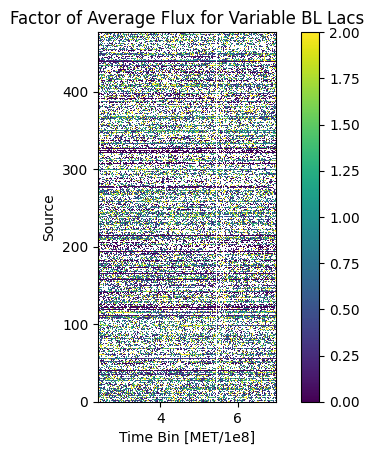

In [99]:

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(bll_fmatrix, aspect=0.02, origin='lower', interpolation='nearest', extent=[TSTART/1e8, TSTOP/1e8, 0, len(bll_fmatrix)])
fig.colorbar(cax)
cax.set_clim(0,2)
ax.set_title("Factor of Average Flux for Variable BL Lacs")
ax.set_xlabel("Time Bin [MET/1e8]")
ax.set_ylabel("Source")
ax.xaxis.set_ticks_position('bottom')

print(len(bll_fmatrix))

In [ ]:
def fvar(flux,flux_err):
	#Based on Equation (34) from K. K. Singh & P. J. Meintjes, Astronomische Nachrichten, Volume 341, Issue 713, pp. 713-725
	#Error calculated with Equation (37) of the same paper

	N=len(flux)
	variance=np.nanvar(flux) #variance
	mean_squared_error=(1/N)*np.nansum(flux_err**2)
	mean_flux=np.nanmean(flux)

	num=variance-mean_squared_error
	den=mean_flux**2

	fvar=np.sqrt(num/den)

	fvar_err=np.sqrt(fvar**2 + np.sqrt((2/N) * (mean_squared_error/den)**2 + (mean_squared_error/N) * (2*fvar/mean_flux)**2 )) - fvar

	return fvar,fvar_err


def fvar_percent(flux,flux_err):
	#Based on Equation (34) from K. K. Singh & P. J. Meintjes, Astronomische Nachrichten, Volume 341, Issue 713, pp. 713-725
	#Error calculated with Equation (37) of the same paper
	#Fvar value (and error) multiplied by 100 to express the fractional variability as a "percentage-scaled" value

	N=len(flux)
	variance=np.nanvar(flux) #variance
	mean_squared_error=(1/N)*np.nansum(flux_err**2)
	mean_flux=np.nanmean(flux)

	num=variance-mean_squared_error
	den=mean_flux**2

	fvar=np.sqrt(num/den)

	fvar_err=np.sqrt(fvar**2 + np.sqrt((2/N) * (mean_squared_error/den)**2 + (mean_squared_error/N) * (2*fvar/mean_flux)**2 )) - fvar

	return fvar*100,fvar_err*100

In [ ]:
# This tests the flux variability functions with a source. The function automatically overlooks NaN values.
flux = fractionalflux[1][3]
flux_err = fractionalflux[1][4]
print(fvar(flux,flux_err))
print(fvar_percent(flux,flux_err))